In [607]:
import sys 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import preprocessing
from category_encoders import TargetEncoder


In [608]:
df = pd.read_csv('data_01.12.2020_preprocessed.csv', sep=',', parse_dates=['sales_date', 'first_registration'])

In [609]:
df

,sales_date,first_registration,brand,model,modelyear,fuel,listprice,mileage,region,sales_price
0,2017-01-01,2014-02-28,Volkswagen,JETTA (A6),2014.0,G,24255.0,15986.0,Southeast,11800.0
1,2017-01-01,2014-05-30,Volkswagen,JETTA (A6),2014.0,G,22905.0,7123.0,Pacific,10739.0
2,2017-01-01,2013-06-30,Audi,A4 Sedan,2013.0,G,54165.0,28765.0,Pacific,28707.0
3,2017-01-01,2013-01-19,Volkswagen,Passat,2013.0,G,24010.0,50415.0,Pacific,9376.0
4,2017-01-01,2014-03-20,Volkswagen,JETTA (A6),2014.0,G,24585.0,35325.0,Northeast,10500.0
...,...,...,...,...,...,...,...,...,...,...
423218,2019-04-30,2017-03-11,Audi,A4 Sedan,2017.0,G,48775.0,15241.0,Pacific,24800.0
423219,2019-04-30,2018-06-29,Volkswagen,TIGUAN,2018.0,G,23150.0,13176.0,Pacific,12600.0
423220,2019-04-30,2018-03-15,Volkswagen,TIGUAN,2017.0,G,26995.0,44045.0,Pacific,12000.0
423221,2019-04-30,2018-03-23,Volkswagen,TIGUAN,2017.0,G,27025.0,18601.0,Midwest,14600.0


#Data preprocessing - Continued

## Handling categorical features

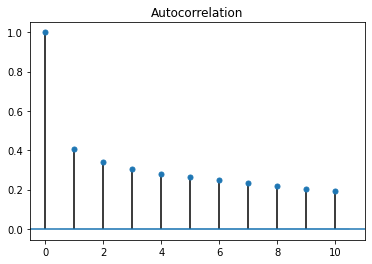

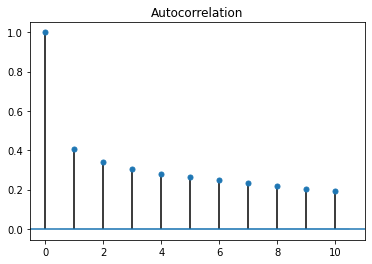

In [610]:
#Handle Date attributes
#Create column for day,month, year, dayofweek, quarter information for date attributes
df['sales_date_day'] = df['sales_date'].dt.day
df['sales_date_month'] = df['sales_date'].dt.month
df['sales_date_year'] = df['sales_date'].dt.year
df['sales_date_dayofweek'] = df['sales_date'].dt.dayofweek
df['sales_date_quarter'] = df['sales_date'].dt.quarter

df['first_registration_day'] = df['first_registration'].dt.day
df['first_registration_month'] = df['first_registration'].dt.month
df['first_registration_year'] = df['first_registration'].dt.year
df['first_registration_dayofweek'] = df['first_registration'].dt.dayofweek
df['first_registration_quarter'] = df['first_registration'].dt.quarter

#Autocorrelation with past 10lags for sales_price
plot_acf(df['sales_price'], lags=10)

In [611]:
#Add lag 1 as a feature
df['sales_price_lag1'] = df['sales_price'].shift(1)
df = df.fillna(0) #Add 0 as the lag1 to first record
df

,sales_date,first_registration,brand,model,modelyear,fuel,listprice,mileage,region,sales_price,sales_date_day,sales_date_month,sales_date_year,sales_date_dayofweek,sales_date_quarter,first_registration_day,first_registration_month,first_registration_year,first_registration_dayofweek,first_registration_quarter,sales_price_lag1
0,2017-01-01,2014-02-28,Volkswagen,JETTA (A6),2014.0,G,24255.0,15986.0,Southeast,11800.0,1,1,2017,6,1,28,2,2014,4,1,0.0
1,2017-01-01,2014-05-30,Volkswagen,JETTA (A6),2014.0,G,22905.0,7123.0,Pacific,10739.0,1,1,2017,6,1,30,5,2014,4,2,11800.0
2,2017-01-01,2013-06-30,Audi,A4 Sedan,2013.0,G,54165.0,28765.0,Pacific,28707.0,1,1,2017,6,1,30,6,2013,6,2,10739.0
3,2017-01-01,2013-01-19,Volkswagen,Passat,2013.0,G,24010.0,50415.0,Pacific,9376.0,1,1,2017,6,1,19,1,2013,5,1,28707.0
4,2017-01-01,2014-03-20,Volkswagen,JETTA (A6),2014.0,G,24585.0,35325.0,Northeast,10500.0,1,1,2017,6,1,20,3,2014,3,1,9376.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423218,2019-04-30,2017-03-11,Audi,A4 Sedan,2017.0,G,48775.0,15241.0,Pacific,24800.0,30,4,2019,1,2,11,3,2017,5,1,15250.0
423219,2019-04-30,2018-06-29,Volkswagen,TIGUAN,2018.0,G,23150.0,13176.0,Pacific,12600.0,30,4,2019,1,2,29,6,2018,4,2,24800.0
423220,2019-04-30,2018-03-15,Volkswagen,TIGUAN,2017.0,G,26995.0,44045.0,Pacific,12000.0,30,4,2019,1,2,15,3,2018,3,1,12600.0
423221,2019-04-30,2018-03-23,Volkswagen,TIGUAN,2017.0,G,27025.0,18601.0,Midwest,14600.0,30,4,2019,1,2,23,3,2018,4,1,12000.0


In [612]:
#Find the index of 1st April, 2019 from which test data starts
test_data_start_index  = (df['sales_date'].dt.strftime('%Y-%m-%d') == '2019-04-01').idxmax()
#95% train and 5% validation split
validation_data_start_index = int(test_data_start_index *0.95)
print('Test data starts at index', test_data_start_index)
print('Validation data starts at index', validation_data_start_index)

df = df.drop(columns=['sales_date', 'first_registration'])
df = df[[c for c in df if c not in ['sales_price']]  + ['sales_price']] #Reorder column positions and place sales_price at last

#Create train, validation and test datasets
train = (df.loc[:validation_data_start_index, :])
validation = (df.loc[validation_data_start_index: test_data_start_index, :])
test = (df.loc[test_data_start_index:, :])

train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
validation_X, validation_y = validation.iloc[:, :-1], validation.iloc[:, -1]
test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]

Test data starts at index 402616
Validation data starts at index 382485


In [ ]:
categorical_columns = ['brand', 'model', 'region', 'fuel']

# In TargetEncoder, the categorical value is replaced with the probability of the target given a particular categorical value 
# It is said to be a better alternative to LabelEncoding and OneHotEncoding
enc = TargetEncoder(cols=categorical_columns)

# Fit on training data and transform test and validation data
enc = enc.fit(train_X, train_y)
train_X = enc.transform(train_X)
validation_X = enc.transform(validation_X)
test_X = enc.transform(test_X)


In [614]:
train = pd.concat([train_X, train_y], axis=1)
validation = pd.concat([validation_X, validation_y], axis=1)
test = pd.concat([test_X, test_y], axis=1)


# Outlier removal - As outliers are observed during visualization, we remove them

In [615]:
from scipy import stats
z = np.abs(stats.zscore(train))
threshold = 3
x, y = np.where(z > 3)
#Use zscore to remove outlier
train = train[(z < 3).all(axis=1)]
print('Identified number of outliers', x.shape[0])

Identified number of outliers 30808


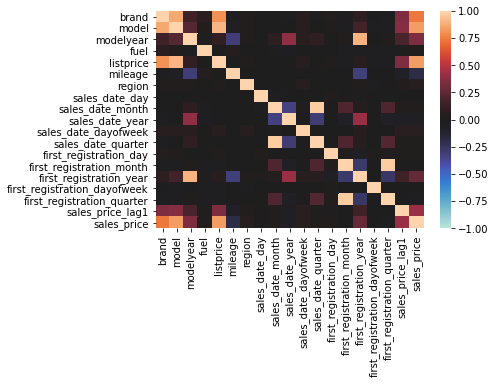

In [616]:
#Plot correlation among features for the preprocessed data
sns.heatmap(pd.DataFrame(train).corr(), vmin=-1, vmax=1, center=0) 

In [617]:
#Scale dataset after removing outliers
def scaleDataset(train, validation, test):
	# scaler = MinMaxScaler(feature_range=(0, 5))
 	# scaler = StandardScaler()
  scaler = RobustScaler() #Model tuning is done based on different Scalers, and RobustScaler is selected

  scaler = scaler.fit(train)
  scaledTrain = scaler.transform(train)
  scaledValidation = scaler.transform(validation)
  scaledTest = scaler.transform(test)
  return scaledTrain, scaledValidation, scaledTest, scaler

train, validation, test, scaler = scaleDataset(train, validation, test)

#Model building

In [618]:
train_X, train_y = train[:, :-1], train[:, -1]
validation_X, validation_y = validation[:, :-1], validation[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to [examples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape) 


(356188, 1, 18) (356188,) (20132, 1, 18) (20132,) (20607, 1, 18) (20607,)


In [619]:
def LSTM_MODEL():
  model = models.Sequential()
  #model is tuned with varying LSTM and Dense layer units
  model.add(layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(layers.Dense(1, activation='linear'))
  model.compile(loss='mae', optimizer='adam', metrics=[ 'mse', 'mae'])
  return model

In [556]:
model = LSTM_MODEL()
model.summary()

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 100)               47600     
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 101       
Total params: 47,701
Trainable params: 47,701
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1495/1495 [==============================] - 9s 6ms/step - loss: 0.1681 - mse: 0.1681 - mae: 0.2221 - val_loss: 0.1176 - val_mse: 0.1176 - val_mae: 0.2050
Epoch 2/10
1495/1495 [==============================] - 9s 6ms/step - loss: 0.1379 - mse: 0.1379 - mae: 0.1969 - val_loss: 0.1165 - val_mse: 0.1165 - val_mae: 0.2040
Epoch 3/10
1495/1495 [==============================] - 9s 6ms/step - loss: 0.1355 - mse: 0.1355 - mae: 0.1941 - val_loss: 0.1174 - val_mse: 0.1174 - val_mae: 0.2067
Epoch 4/10
1495/1495 [==============================] - 9s 6ms/step - loss: 0.1346 - mse: 0.1346 - mae: 0.1927 - val_loss: 0.1182 - val_mse: 0.1182 - val_mae: 0.2092
Epoch 5/10
1495/1495 [==============================] - 9s 6ms/step - loss: 0.1339 - mse: 0.1339 - mae: 0.1917 - val_loss: 0.1180 - val_mse: 0.1180 - val_mae: 0.2094
Epoch 6/10
1495/1495 [==============================] - 9s 6ms/step - loss: 0.1334 - mse: 0.1334 - mae: 0.1907 - val_loss: 0.1172 - val_mse: 0.1172 - val_mae: 0.2079
Epoc

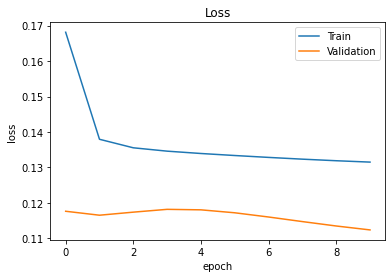

In [557]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) 
# EarlyStopping is avoided as model is found to underfit. 
# So all the typical regularization techniques like adding Dropout to layers, L1, L2 regularization, adding GaussianNoise is prevented

history = model.fit(train_X, train_y, epochs=10, batch_size=256, validation_data=(validation_X, validation_y), verbose=1, shuffle=False)
model.save('model_10epochs')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'])
plt.show()


In [562]:
# This method inverts the scaling of predicted and target attribute and calculates RMSE and MAE errors
def predict(X, y, model):
  y_predicted = model.predict(X)
  X = tf.reshape(X, (X.shape[0], X.shape[2]))
  y_predicted = scaler.inverse_transform(np.concatenate((X, y_predicted), axis=1))[:,-1]
  y_target = scaler.inverse_transform(np.concatenate((X, y), axis=1))[:,-1]

  rmse = np.sqrt(mean_squared_error(y_predicted, y_target))
  mae = mean_absolute_error(y_predicted, y_target)
  print('Root Mean Square Error(RMSE)', rmse, 'Mean Absolute Error (MAE)', mae, end='\n\n')

print('Error in Training dataset')
predict(train_X, train_y.reshape(-1,1), model)
print('Error in Validation dataset')
predict(validation_X, validation_y.reshape(-1,1), model)
print('Error in Test dataset')
predict(test_X, test_y.reshape(-1,1), model)


Error in Training dataset
Root Mean Square Error(RMSE) 4759.475214288724 Mean Absolute Error (MAE) 2473.0614522258243

Error in Validation dataset
Root Mean Square Error(RMSE) 4375.696792491352 Mean Absolute Error (MAE) 2565.424940049981

Error in Test dataset
Root Mean Square Error(RMSE) 4283.45292107201 Mean Absolute Error (MAE) 2605.229188745824



### Conclusion: From the above plot to catpure loss in train and validation datasets with epochs, we can see that the model is underfitting because of high loss and moreover the training loss is greater than the validation loss

# Testing with different optimizers

In [563]:
def fitModelWithOptimizer(optimizer):
    model = LSTM_MODEL()
    model.compile(loss='mae', optimizer=optimizer, metrics=[ 'mse', 'mae'])
    history = model.fit(train_X, train_y, epochs=10, batch_size=256, validation_data=(validation_X, validation_y), verbose=0, shuffle=False)

def draw_plot(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training and Validation data loss for '+name)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'])
  plt.show()


history_adam, model_adam = fitModelWithOptimizer('adam')
history_rmsprop, model_rmsprop = fitModelWithOptimizer('RMSprop')
history_adadelta, model_adadelta = fitModelWithOptimizer('Adadelta')
history_sgd, model_sgd = fitModelWithOptimizer('SGD')

In [565]:
print('Error in Validation dataset with Adam')
predict(validation_X, validation_y.reshape(-1,1), model_adam)

print('Error in Validation dataset with RMSprop')
predict(validation_X, validation_y.reshape(-1,1), model_rmsprop)

print('Error in Validation dataset with Adadelta')
predict(validation_X, validation_y.reshape(-1,1), model_adadelta)

print('Error in Validation dataset with SGD')
predict(validation_X, validation_y.reshape(-1,1), model_sgd)

Error in Validation dataset with Adam
Root Mean Square Error(RMSE) 4285.709927236732 Mean Absolute Error (MAE) 2218.8632940737452

Error in Validation dataset with RMSprop
Root Mean Square Error(RMSE) 4365.225846023114 Mean Absolute Error (MAE) 2539.8814702994387

Error in Validation dataset with Adadelta
Root Mean Square Error(RMSE) 7929.630245611143 Mean Absolute Error (MAE) 4572.918718435958

Error in Validation dataset with SGD
Root Mean Square Error(RMSE) 4507.839061044571 Mean Absolute Error (MAE) 2387.1773647033506



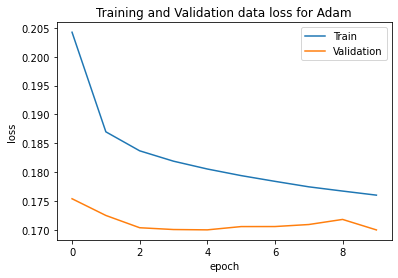

In [567]:
draw_plot(history_adam,'Adam') #Converges a little faster than other optimizers but still underfits the data

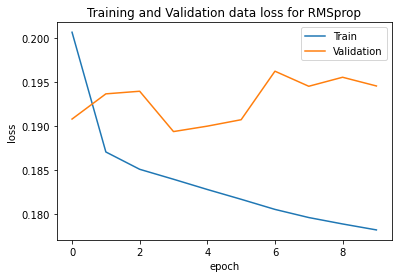

In [568]:
draw_plot(history_rmsprop,'RMSprop') #Overfits the validation data as loss increases with epoch

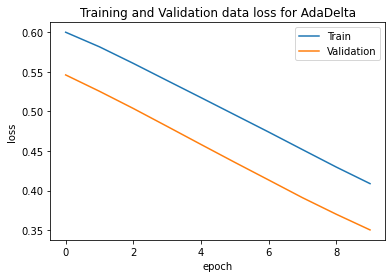

In [569]:
draw_plot(history_adadelta,'AdaDelta') #Contains very high bias and coverges slower than others

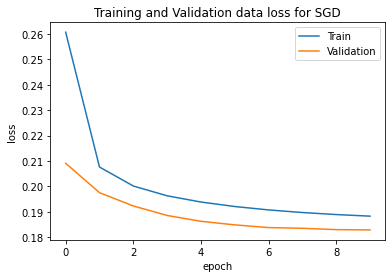

In [570]:
draw_plot(history_sgd,'SGD') #Contains high bias and converges slower than Adam

### Conclusion: From the above graphs, we can choose Adam over other optimizers for our model and dataset

In [620]:
#Load pretrained models with 100 and 500 epochs built with Adam optimizer
model = models.load_model('model_100epochs')

print('----- Model on 100 epochs-----')
print('Error in Training dataset')
predict(train_X, train_y.reshape(-1,1), model)
print('Error in Validation dataset')
predict(validation_X, validation_y.reshape(-1,1), model)
print('Error in Test dataset')
predict(test_X, test_y.reshape(-1,1), model)

model = models.load_model('model_500epochs')

print('\n\n----- Model on 500 epochs-----')
print('Error in Training dataset')
predict(train_X, train_y.reshape(-1,1), model)
print('Error in Validation dataset')
predict(validation_X, validation_y.reshape(-1,1), model)
print('Error in Test dataset')
predict(test_X, test_y.reshape(-1,1), model)




----- Model on 100 epochs-----
Error in Training dataset
RMSE 3481.9058255928653 MAE 2005.3411015882748
Error in Validation dataset
RMSE 4280.1024311288575 MAE 2333.1388992039238
Error in Test dataset
RMSE 4160.457349023292 MAE 2463.641079156667


----- Model on 500 epochs-----
Error in Training dataset
RMSE 3549.9383036037098 MAE 2150.856142950598
Error in Validation dataset
RMSE 4413.525050629428 MAE 2424.9510476068795
Error in Test dataset
RMSE 4252.525751027361 MAE 2483.0105369353328


Training and Validation data loss for 100 Epochs

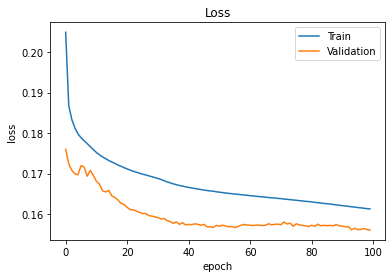

Training and Validation data loss for 500 Epochs

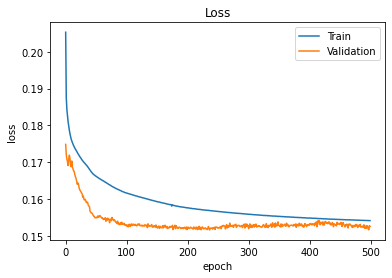

In [555]:
#Finds the best combination of parameters by tuning the hyperparameters: batch_size, epochs
def HyperparametertuneModelParams(batch_size, epoch):
  global test_y
  model = LSTM_MODEL()
  history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch_size, validation_data=(validation_X, validation_y), verbose=0, shuffle=False)
  print('Batch_size', batch_size, 'Epochs', epoch)
  predict(validation_X, validation_y.reshape(-1,1), model)

batch_sizes = [64,128,256]
epochs = [5, 10, 15]

for batch_size in batch_sizes:
  for epoch in epochs:
    HyperparametertuneModelParams(batch_size, epoch)


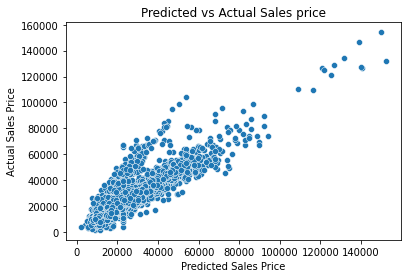

In [625]:
#Analyze the predictions for the model trained on 100epochs
model = models.load_model('model_100epochs')

y_predicted = model.predict(test_X)
X = tf.reshape(test_X, (test_X.shape[0], test_X.shape[2]))
y_predicted = scaler.inverse_transform(np.concatenate((X, y_predicted), axis=1))[:,-1]
y_target = scaler.inverse_transform(np.concatenate((X, test_y.reshape(-1,1)), axis=1))[:,-1]

ax = sns.scatterplot(x=y_predicted, y=y_target)
plt.title('Predicted vs Actual Sales price')
plt.xlabel('Predicted Sales Price')
plt.ylabel('Actual Sales Price')
plt.show()

### Conclusion: We can conclude that LSTM is not a right fit for the given data as the best RMSE (4160.457) and MAE (2463.641) achieved is still not convincing. With the addition of more features, LSTM might perform well. It is recommended to explore other predictive models for this task.